# Qwen finetune

In [2]:
states = {
	'stage_0': {
		'name': 'base_plate',
		'description': 'I can see the base plate, therefore the object must be in stage_0'
	},
	'stage_1': {
		'name': 'cylinder',
		'description': 'I can see the cylinder being on top of the base plate, therefore the object must be in stage_1'
	},
	'stage_2': {
		'name': 'big_metal_piece',
		'description': 'I can see the big metal piece being on top of the cylinder, therefore the object must be in stage_2'
	},
	'stage_3': {
		'name': 'small_metal_piece',
		'description': 'I can see the small metal piece being on placed in the middle of the big metal piece, therefore the object must be in stage_3'
	},
	'stage_4': {
		'name': 'metal_ring',
		'description': 'I can see the small metal ring being placed in the center of the small metal piece, therefore the object must be in stage_4'
	},
	'stage_5': {
		'name': 'screws',
		'description': 'I can see the 3 screws being screwed on the metal plate, therefore the object must be in stage_5'
	},
	'stage_6': {
		'name': 'metal_plate',
		'description': 'I can see the daker metal plate being placed on top of the object, therefore the object must be in stage_6'
	},
	'stage_7': {
		'name': 'final_plate',
		'description': 'I can see 5 screws being screwed on the metal plate, therefore the object must be in stage_7'
	}
}

'''
I have a folder of folders with name stage_0, stage_1, ..., stage_7.
Each folder contains a folder with name images. I need you to create a folder which i will supply parameter, for that folder
you need to create 2 subfolders: images, annotations. the image you can just copy from the stage_x but you only must copy images
if the name does not contain _colorpatch and _sam.
For the annotation you need to create a txt file for each image with the same name.that file must contain the text from
state[stage_x][description].
Take as parameter the input and the output folder.
'''

'''
You job is it tell me what you see in the image, and if possible what stage the object is currently in.
Here are the possible states:
	'state_0': 'First part of the object: Base block metal piece',
	'state_1': 'Second part of the object: Cylinder metal piece which gets stick on the base block stage_0',
	'state_2': 'Third part of the object: A Big metal piece which gets stick on the cylinder piece of stage_1',
	'state_3': 'Fourth part of the object: A smaller thin metal piece which gets put onto the center of the big metal piece of stage_2',
	'state_4': 'Fifth part of the object: A tiny metal ring which gets placed onto the center of the thing metal piece of stage_3',
	'state_5': 'Sixth part of the object: 3 screws now get screwed onto the piece',
	'state_6': 'Seventh part of the object: A darker metal plate now gets placed on top of the piece',
	'state_7': 'Eighth part of the object: 5 screws now get screwed onto the piece'
'''







_colorpatch
_sam

In [20]:
from pathlib import Path
import shutil

# STAGE_DESCRIPTIONS = {
#     "stage_0": "I can see the base plate, therefore the object must be in stage_0",
#     "stage_1": "I can see the cylinder being on top of the base plate, therefore the object must be in stage_1",
#     "stage_2": "I can see the big metal piece being on top of the cylinder, therefore the object must be in stage_2",
#     "stage_3": "I can see the small metal piece being on placed in the middle of the big metal piece, therefore the object must be in stage_3",
#     "stage_4": "I can see the small metal ring being placed in the center of the small metal piece, therefore the object must be in stage_4",
#     "stage_5": "I can see the 3 screws being screwed on the metal plate, therefore the object must be in stage_5",
#     "stage_6": "I can see the daker metal plate being placed on top of the object, therefore the object must be in stage_6",
#     "stage_7": "I can see 5 screws being screwed on the metal plate, therefore the object must be in stage_7",
# }
STAGE_DESCRIPTIONS = {
    "stage_0": "I can see the base plate, which is the main piece of stage_0",
    "stage_1": "I can see the cylinder the main piece of stage_1",
    "stage_2": "I can see the big metal piecethe main piece of stage_2",
    "stage_3": "I can see the smaller metal thinner piece the main piece of stage_3",
    "stage_4": "I can see the small metal ring the main piece of stage_5",
    "stage_5": "I can see 3 screws",
    "stage_6": "I can see the darker metal plate the main piece of stage_6",
    "stage_7": "I can see 5 screws",
}


def process_stage(stage: str, src_root, dst_root) -> None:
    """Copy images for one stage and write annotation files.

    `src_root` and `dst_root` can be Path objects **or** plain strings."""
    src_root = Path(src_root)
    dst_root = Path(dst_root)

    src_dir = src_root / "images" / stage
    if not src_dir.is_dir():
        print(f"Warning: {src_dir} is missing, skipping.")
        return

    dst_img_dir = dst_root / "images" / stage
    dst_ann_dir = dst_root / "anno" / stage
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_ann_dir.mkdir(parents=True, exist_ok=True)

    desc_text = STAGE_DESCRIPTIONS[stage]

    for img_path in src_dir.iterdir():
        if img_path.is_dir():
            continue
        name = img_path.name
        if "_colorpatch" in name or "_sam" in name:
            continue

        shutil.copy2(img_path, dst_img_dir / name.replace('.jpg', '_solo.jpg'))
        (dst_ann_dir / f"{img_path.stem}_solo.txt").write_text(desc_text, encoding="utf-8")


# Example manual call (now works with strings):
process_stage(
    "stage_7",
    "/Users/georgye/Documents/repos/ethz/dslab25/assets/vacuum_pump/rendered_single",
    "/Users/georgye/Documents/repos/ethz/dslab25/training/qwen",
)

In [39]:

def pca_color_feature(feature_map, n_components=3):
	"""
	Apply PCA to a feature map and reduce it to n_components (3 for RGB).

	Parameters:
	  feature_map: a torch.Tensor of shape (channels, height, width)
	  n_components: the number of PCA components (default is 3)

	Returns:
	  A normalized image tensor of shape (height, width, n_components) with values in [0, 1].
	"""
	# Rearrange feature_map to shape (height, width, channels)
	fm = feature_map.permute(1, 2, 0)   # (H, W, C)
	H, W, C = fm.shape

	# Flatten the spatial dimensions: shape -> (H*W, C)
	fm_flat = fm.reshape(-1, C)
	
	# Compute PCA using torch.pca_lowrank, reducing to n_components.
	# This returns U, S, V such that fm_flat ≈ U @ diag(S) @ V.T
	U, S, V = torch.pca_lowrank(fm_flat, q=n_components)
	
	# Project the flattened feature vectors onto the PCA space using V.
	# V has shape (n_components, C). The projection is given by:
	reduced = torch.matmul(fm_flat, V)  # shape: (H*W, n_components)
	
	# Reshape the reduced features back to (H, W, n_components)
	reduced = reduced.reshape(H, W, n_components)
	
	# Normalize each PCA channel to [0, 1] for display.
	flat_reduced = reduced.reshape(-1, n_components)
	min_vals = flat_reduced.min(dim=0)[0]
	max_vals = flat_reduced.max(dim=0)[0]
	normalized = (reduced - min_vals) / (max_vals - min_vals + 1e-5)

	return normalized

def display_edges_with_pca(image_path):
	"""
	Load an image from disk, extract a feature map via SAM's image encoder,
	and use PCA to reduce the features to 3 channels (RGB). The result
	highlights edges and high-variance features.
	
	Parameters:
	  image_path (str): Path to a jpg or png image.
	"""
	device = "cuda" if torch.cuda.is_available() else "cpu"
	
	# Load the SAM model and processor.)
	model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
	
	# Load the image and convert it to RGB.
	raw_image = Image.open(image_path).convert("RGB")
	
	start_time = time.time()
	print("time start: ", start_time)
	# Process the image using the processor.
	# Note: Instead of calling 'processor.preprocess', we directly call the processor.
	inputs = processor(raw_image, return_tensors="pt")
	inputs = {k: v.to(device) for k, v in inputs.items()}
	
	# Extract a feature map using the image encoder.
	with torch.no_grad():
		feature_map = model.get_image_embeddings(inputs["pixel_values"])
	
	# Assume the output has shape (B, C, H, W); take the first image in the batch.
	feature_map = feature_map[0]  # shape: (C, H, W)
	
	# Apply PCA to the feature map to reduce it to 3 channels.
	pca_result = pca_color_feature(feature_map)  # shape: (H, W, 3)
	print("time taken: ", time.time() - start_time)
	
	# Display the PCA-reduced feature map.
	plt.figure(figsize=(10, 10))
	plt.imshow(pca_result.cpu().detach().numpy())
	plt.title("PCA Reduced Feature Map (Edges Emphasized)")
	plt.axis("off")
	plt.show()

# Example usage:
# Replace the path below with the location of your local image.
# display_edges_with_pca("path/to/your/image.jpg")

time start:  1744565365.4930747
time taken:  0.32704687118530273


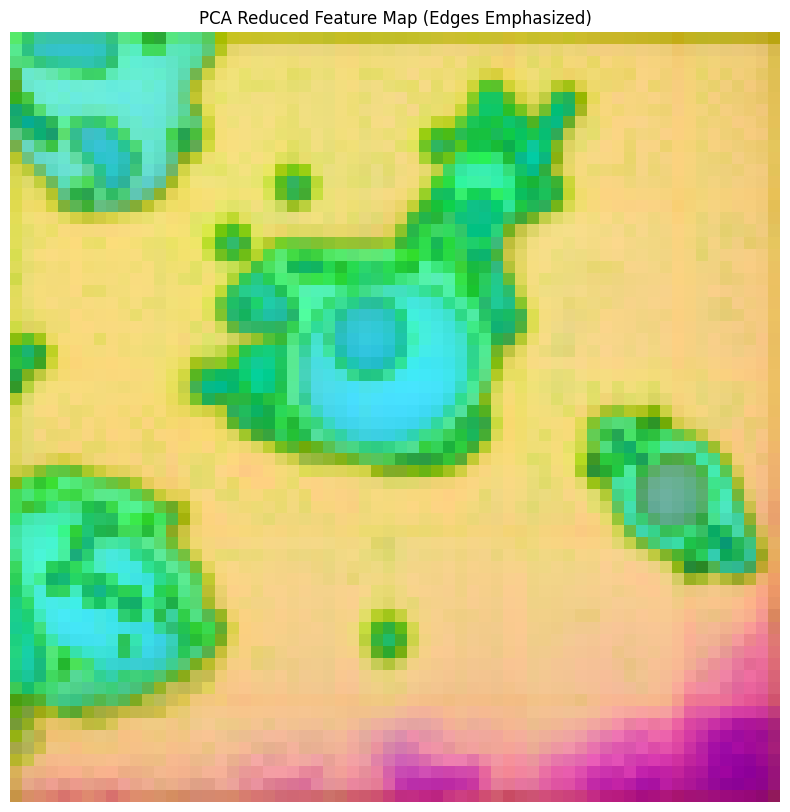

In [40]:
display_edges_with_pca("/workspace/dslab25/training/vacuum_pump/images/original/stage_0/stage_0_var_1_case_render_8.jpg")
# segment_image_with_all_masks("path/to/your/image.jpg", segmentation_map_path="path/to/segmentation_map.png")

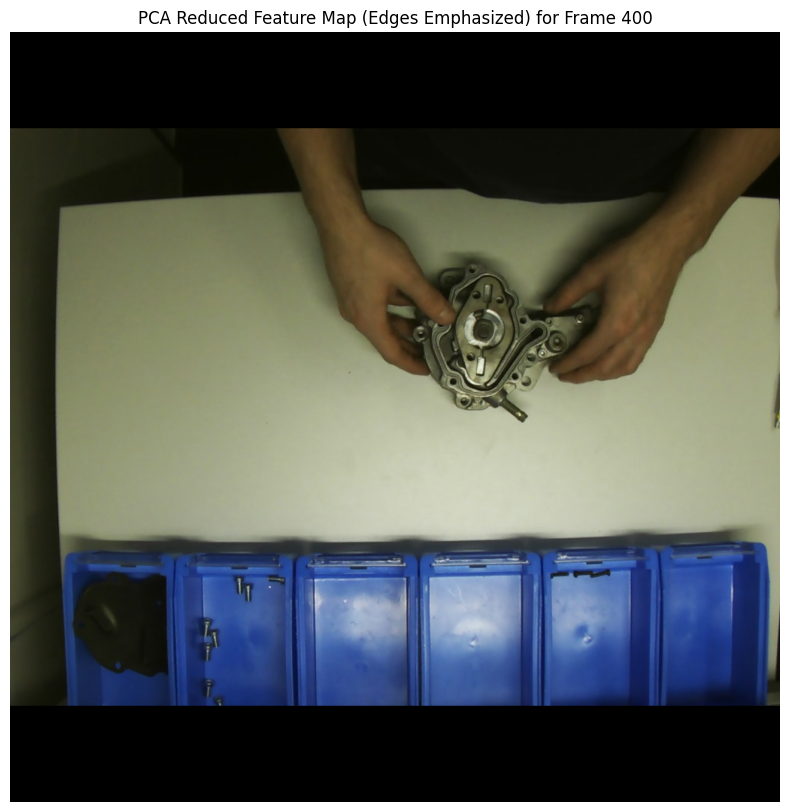

In [5]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor

def pca_color_feature(feature_map, n_components=3):
	"""
	Apply PCA to a feature map and reduce it to n_components (3 for RGB).
	
	Parameters:
	  feature_map: a torch.Tensor of shape (channels, height, width)
	  n_components: the number of PCA components (default is 3)
	  
	Returns:
	  A normalized image tensor of shape (height, width, n_components) with values in [0, 1].
	"""
	# Rearrange feature_map to shape (H, W, C)
	fm = feature_map.permute(1, 2, 0)  # shape: (H, W, C)
	H, W, C = fm.shape

	# Flatten the spatial dimensions: shape -> (H*W, C)
	fm_flat = fm.reshape(-1, C)
	
	# Compute PCA using torch.pca_lowrank, reducing to n_components.
	# This returns U, S, V such that fm_flat ≈ U @ diag(S) @ V.T.
	U, S, V = torch.pca_lowrank(fm_flat, q=n_components)
	
	# V has shape (C, n_components), so project by multiplying X @ V.
	reduced = torch.matmul(fm_flat, V)  # shape: (H*W, n_components)
	
	# Reshape back to (H, W, n_components).
	reduced = reduced.reshape(H, W, n_components)
	
	# Normalize each channel to the range [0, 1].
	flat_reduced = reduced.reshape(-1, n_components)
	min_vals = flat_reduced.min(dim=0)[0]
	max_vals = flat_reduced.max(dim=0)[0]
	normalized = (reduced - min_vals) / (max_vals - min_vals + 1e-5)
	
	return normalized

def process_video_frame(video_path, target_frame_idx=1000):
	"""
	Reads the target_frame_idx-th frame from a video file, uses SAM's image encoder to
	obtain a feature map, applies PCA to reduce it to 3 channels (RGB), and displays the
	result.

	Parameters:
	  video_path (str): Path to the video file.
	  target_frame_idx (int): Index of the frame to process (default is 1000).
	"""
	device = "cuda" if torch.cuda.is_available() else "cpu"
	
	# Open the video and iterate until we reach the target frame.
	cap = cv2.VideoCapture(video_path)
	current_idx = 0
	target_frame = None
	while True:
		ret, frame = cap.read()
		if not ret:
			break
		if current_idx == target_frame_idx:
			target_frame = frame
			break
		current_idx += 1
	cap.release()
	
	if target_frame is None:
		print(f"Frame {target_frame_idx} was not found in the video.")
		return
	
	# Convert the frame from BGR (OpenCV) to RGB and create a PIL Image.
	frame_rgb = cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)
	image = Image.fromarray(frame_rgb)
	
	# Load the SAM model and processor.
	# model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
	# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
	
	# # Process the image. Instead of a .preprocess method, we simply call the processor.
	# inputs = processor(image, return_tensors="pt")
	# inputs = {k: v.to(device) for k, v in inputs.items()}
	
	# # Extract the feature map using the image encoder.
	# with torch.no_grad():
	# 	feature_map = model.get_image_embeddings(inputs["pixel_values"])
		
	# # SAM's image encoder outputs a tensor with shape (B, C, H, W).
	# feature_map = feature_map[0]  # Use the first image in the batch.
	
	# # Apply PCA to the feature map.
	# pca_result = pca_color_feature(feature_map)  # shape: (H, W, 3)
	
	# Display the result.
	plt.figure(figsize=(10, 10))
	plt.imshow(frame_rgb)
	plt.title(f"PCA Reduced Feature Map (Edges Emphasized) for Frame {target_frame_idx}")
	plt.axis("off")
	plt.show()

# Example usage:
# Replace 'path/to/your/video.mp4' with the path to your video file.
# This will process the 1000th frame of the video.
process_video_frame("/Users/georgye/Documents/repos/ethz/dslab25/assets/vacuum_pump/videos/01_run1_cam_2_1024x1024_15fps_3mbps.mp4", target_frame_idx=400)

# Converting whole folder

In [7]:
repo_dir = os.getcwd().split('dslab25')[0] + 'dslab25/'
base_dir_images = os.path.join(repo_dir, "assets/vacuum_pump/eval/original/image")
base_dir_annotations = os.path.join(repo_dir, "assets/vacuum_pump/eval/original/class")
out_base_images = os.path.join(repo_dir, "assets/vacuum_pump/eval/sam/image")
out_base_annotations = os.path.join(repo_dir, "assets/vacuum_pump/eval/sam/class")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model and processor.
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
def pca_color_feature(feature_map, n_components=3):
	"""
	Apply PCA to a feature map and reduce it to n_components (3 for RGB).

	Parameters:
	  feature_map: a torch.Tensor of shape (channels, height, width)
	  n_components: the number of PCA components (default is 3)

	Returns:
	  A normalized image tensor of shape (height, width, n_components) with values in [0, 1].
	"""
	# Rearrange feature_map to shape (height, width, channels)
	fm = feature_map.permute(1, 2, 0)   # (H, W, C)
	H, W, C = fm.shape

	# Flatten the spatial dimensions: shape -> (H*W, C)
	fm_flat = fm.reshape(-1, C)
	
	# Compute PCA using torch.pca_lowrank, reducing to n_components.
	# This returns U, S, V such that fm_flat ≈ U @ diag(S) @ V.T
	U, S, V = torch.pca_lowrank(fm_flat, q=n_components)
	
	# Project the flattened feature vectors onto the PCA space using V.
	# V has shape (C, n_components), so use:
	reduced = torch.matmul(fm_flat, V)  # shape: (H*W, n_components)
	
	# Reshape the reduced features back to (H, W, n_components)
	reduced = reduced.reshape(H, W, n_components)
	
	# Normalize each PCA channel to [0, 1] for display.
	flat_reduced = reduced.reshape(-1, n_components)
	min_vals = flat_reduced.min(dim=0)[0]
	max_vals = flat_reduced.max(dim=0)[0]
	normalized = (reduced - min_vals) / (max_vals - min_vals + 1e-5)

	return normalized

def display_edges_with_pca(image_path, output_file=None):
	"""
	Load an image from disk, extract a feature map via SAM's image encoder,
	and use PCA to reduce the features to 3 channels (RGB). The result
	highlights edges and high-variance features.
	
	Parameters:
	  image_path (str): Path to a jpg or png image.
	  output_file (str, optional): Path where the output image will be saved.
								   If None, the image is displayed.
	"""
	
	# Load the image and convert it to RGB.
	raw_image = Image.open(image_path).convert("RGB")
	
	# Process the image using the processor.
	inputs = processor(raw_image, return_tensors="pt")
	inputs = {k: v.to(device) for k, v in inputs.items()}
	
	# Extract a feature map using the image encoder.
	with torch.no_grad():
		# Using get_image_embeddings is equivalent to calling the image encoder.
		feature_map = model.get_image_embeddings(inputs["pixel_values"])
	
	# Assume the output has shape (B, C, H, W); take the first image in the batch.
	feature_map = feature_map[0]  # shape: (C, H, W)
	
	# Apply PCA to the feature map to reduce it to 3 channels.
	pca_result = pca_color_feature(feature_map)  # shape: (H, W, 3)
	
	# Either save the image or show it.
	if output_file is not None:
		np_img = pca_result.cpu().detach().numpy()
		np_img = (np_img * 255).astype(np.uint8)

		# Resize PCA result to match original image resolution
		original_size = raw_image.size  # (width, height)
		np_img_resized = cv2.resize(np_img, original_size, interpolation=cv2.INTER_CUBIC)
		
		# Convert RGB -> BGR and save with OpenCV
		np_img_bgr = cv2.cvtColor(np_img_resized, cv2.COLOR_RGB2BGR)
		cv2.imwrite(output_file, np_img_bgr)
	else:
		# Create a figure and display the PCA-reduced feature map.
		plt.figure(figsize=(10, 10))
		plt.imshow(pca_result.cpu().detach().numpy())
		plt.title("PCA Reduced Feature Map (Edges Emphasized)")
		plt.axis("off")
		
		plt.show()

image_files = [f for f in os.listdir(base_dir_images) if f.lower().endswith(".jpg")]

for filename in image_files:
	image_path = os.path.join(base_dir_images, filename)
	base_filename = os.path.splitext(filename)[0]
	annotation_filename = base_filename + ".txt"
	annotation_path = os.path.join(base_dir_annotations, annotation_filename)
	
	out_image_filename = f"{base_filename}.jpg"
	out_annotation_filename = f"{base_filename}.txt"
	out_image_path = os.path.join(out_base_images, out_image_filename)
	
	if not os.path.exists(out_image_path):
		# Apply the random translation augmentation.
		display_edges_with_pca(image_path, out_image_path)

		# Copy annotation unchanged.
		if os.path.exists(annotation_path):
			with open(annotation_path, 'r') as f:
				content = f.read()
			out_annotation_path = os.path.join(out_base_annotations, f"{base_filename}.txt")
			with open(out_annotation_path, 'w') as f:
				f.write(content)
		print(f"Processed sam augmentation: {out_image_path}")

# Example usage:
# Replace the path below with the location of your local image.
# display_edges_with_pca("path/to/your/image.jpg")

Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_100.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1000.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1005.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1010.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1015.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1020.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1025.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1030.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1035.jpg
Processed sam augmentation: /workspace/dslab25/assets/vacuum_pump/eval/sam/image/frame_1040.jpg
Processed sam augmentation: /workspace/ds

In [26]:
#!/usr/bin/env python3
"""
prepare_qwen25vl_data.py
------------------------
Build the folder hierarchy and JSONL annotation files required to fine‑tune
Qwen‑2.5‑VL on your assembly‑stage images.

Images:  {images_root}/stage_k/XXXX.jpg
Labels:  {labels_root}/stage_k/XXXX.txt   (same relative path & basename)
"""

import json
import random
import shutil
from pathlib import Path
from typing import List, Tuple

# ────────────────────────────────────────────────────────────────────────────────
SYSTEM_MESSAGE = (
    "You job is it tell me what you see in the image, and if possible what stage "
    "the object is currently in.\nHere are the possible states:\n"
    "\t'state_0': 'First part of the object: Base block metal piece',\n"
    "\t'state_1': 'Second part of the object: Cylinder metal piece which gets stick "
    "on the base block stage_0',\n"
    "\t'state_2': 'Third part of the object: A Big metal piece which gets stick on "
    "the cylinder piece of stage_1',\n"
    "\t'state_3': 'Fourth part of the object: A smaller thin metal piece which gets "
    "put onto the center of the big metal piece of stage_2',\n"
    "\t'state_4': 'Fifth part of the object: A tiny metal ring which gets placed "
    "onto the center of the thing metal piece of stage_3',\n"
    "\t'state_5': 'Sixth part of the object: 3 screws now get screwed onto the piece',\n"
    "\t'state_6': 'Seventh part of the object: A darker metal plate now gets placed "
    "on top of the piece',\n"
    "\t'state_7': 'Eighth part of the object: 5 screws now get screwed onto the piece'"
)

USER_PREFIX = (
    "Describe the object and, if you can, tell me which stage (state_0 … state_7) "
    "it is currently in."
)
# ────────────────────────────────────────────────────────────────────────────────


def collect_pairs(img_root: Path, lbl_root: Path) -> List[Tuple[Path, str]]:
    """Return list of (image_path, label_text)."""
    img_root = Path(img_root)
    lbl_root = Path(lbl_root)

    pairs: List[Tuple[Path, str]] = []
    for img_path in img_root.rglob("*.jpg"):
        rel = img_path.relative_to(img_root)
        lbl_path = lbl_root / rel.with_suffix(".txt")
        if not lbl_path.exists():
            raise FileNotFoundError(f"Missing label file for image: {img_path}")
        text = lbl_path.read_text(encoding="utf-8").strip()
        pairs.append((img_path, text))

    if not pairs:
        raise RuntimeError("No image/label pairs found – check your paths.")
    return pairs


def split_pairs(
    pairs: List[Tuple[Path, str]], train_split: float, seed: int
) -> Tuple[List[Tuple[Path, str]], List[Tuple[Path, str]]]:
    random.Random(seed).shuffle(pairs)
    cut = int(len(pairs) * train_split)
    return pairs[:cut], pairs[cut:]


def write_jsonl(
    pairs: List[Tuple[Path, str]], out_dir: Path, img_root: Path
) -> None:
    """
    Copy images into out_dir and create annotations.jsonl
    (images are kept at top level of out_dir; stage_*/ sub‑folders are replicated).
    """
    out_dir = Path(out_dir)
    img_root = Path(img_root)
    anno_path = out_dir / "annotations.jsonl"
    out_dir.mkdir(parents=True, exist_ok=True)

    with anno_path.open("w", encoding="utf-8") as f:
        for img_path, label in pairs:
            rel_img = img_path.relative_to(img_root)
            dest_img = out_dir / rel_img
            dest_img.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(img_path, dest_img)

            record = {
                "image": str(rel_img).replace("\\", "/"),  # JSONL wants forward slashes
                "prefix": USER_PREFIX,
                "suffix": label,
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")


# ─── USER‑SPECIFIC PATHS ────────────────────────────────────────────────────────
IMG_ROOT  = Path("/Users/georgye/Documents/repos/ethz/dslab25/training/qwen/images/augmented")
LBL_ROOT  = Path("/Users/georgye/Documents/repos/ethz/dslab25/training/qwen/annotation/augmented")
DATA_ROOT = Path("/Users/georgye/Documents/repos/ethz/dslab25/training/qwen/data")
TRAIN_SPLIT = 0.8
SEED = 32
# ────────────────────────────────────────────────────────────────────────────────

# 1. Pair up images and labels
pairs = collect_pairs(IMG_ROOT, LBL_ROOT)

# 2. Train / val split
train_pairs, val_pairs = split_pairs(pairs, TRAIN_SPLIT, SEED)

# 3. Write datasets
train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"

for dirpath in (train_dir, val_dir):
		if dirpath.exists():
				shutil.rmtree(dirpath)  # start clean

write_jsonl(train_pairs, train_dir, IMG_ROOT)
write_jsonl(val_pairs,  val_dir,  IMG_ROOT)

# 4. Save the system prompt
(DATA_ROOT / "system_message.txt").write_text(SYSTEM_MESSAGE, encoding="utf-8")

# 5. Report
print(
		f"✅  Done.\n"
		f"• Train images: {len(train_pairs)} ➜ {train_dir}\n"
		f"• Val   images: {len(val_pairs)} ➜ {val_dir}\n"
		f"• JSONL files:  {train_dir/'annotations.jsonl'}, {val_dir/'annotations.jsonl'}"
)



✅  Done.
• Train images: 2675 ➜ /Users/georgye/Documents/repos/ethz/dslab25/training/qwen/data/train
• Val   images: 669 ➜ /Users/georgye/Documents/repos/ethz/dslab25/training/qwen/data/val
• JSONL files:  /Users/georgye/Documents/repos/ethz/dslab25/training/qwen/data/train/annotations.jsonl, /Users/georgye/Documents/repos/ethz/dslab25/training/qwen/data/val/annotations.jsonl
